Fig. 5.12 - Hierarchical Bayes and Batting Averages
---------------------------------------

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math

Here we are going to illustrate (empirical) Hierarchical Bayes with a batting average example, reproducing fig 5.12 of Murphy (the theory starts on section 5.6). We have the following vector of batting averages for 18 different players in the 1970 baseball season. The first column is the player's batting average over the first 45 at bats and the second is the player's batting average over the whole season.

The objective is to make the best estimate of the player's batting average over the whole season $\theta_i$ (which we will call the "true" batting average), ie, given the data $\vec{x} = (x_1, \ldots, x_N)$, $x_i$ being i's batting average after 45 at bats, we would like to know $p(\theta_i | \vec{x})$.

First, why not simply use $\hat{\theta}_i = x_i$? Certainly seems like the most immediate one, and the one we always use when making inference. Well, the short answer is that we are throwing information away when we do this. We have 45 data points for each player, but this is a small sample next to the "true" one. However, we can use the other players batting averages as a extra information to make the inference.

To make it more precise, suppose T = 45 and $b_i$ is the number of hits, so that $x_i = b_i/T$. Then the likelihood of $x_i$ is given by:

$$p(x_i | \theta_i) = \binom{T}{b_i} \theta_i^{b_i} (1-\theta_i)^{T - b_i}$$

So that the $\hat{\theta}_i = x_i$ is the maximum likelihood estimator of $x_i$. However, we would like to use prior information we have. By the Bayes theorem:

$$p(\vec{\theta} | \vec{x}) \propto p(\vec{x} | \vec{\theta}) p(\vec{\theta})$$

where $p(\vec{\theta})$ is the prior on the batting averages, which we take as independent, $p(\vec{\theta}) = \prod_i p(\theta_i)$. We may initially think that they should be uniformly distributed in $[0,1]$, because we don't "know" anything about $\theta$. But the heart of Bayesian statistics lie in precising what we know. For example, we don't expect $\theta_i = 0$ or $\theta_i = 1$ to be very likely. No player fails to get a first base or hits all at bats. Therefore we can guess that an uniform prior is not ideal. We also know that the spread of batting averages is not that large: 0.400 is considered an amazing average, and the Mendoza Line is 0.200. These two facts make a strong argument for a Gaussian prior:

$$p(\theta_i | \mu, \tau) \sim \mathcal{N}(\mu, \tau^2)$$

However, we don't know what to put as $\mu$ and $\tau$. Well, we do inference on that too! This is why it's called an _Hierarchical Bayes_. We use Bayes to find out $\theta$ from $x$. But $\theta$ depends on parameters $\vec{\eta} = (\mu, \tau)$, so we use Bayes to find $\vec{\eta}$ from $\vec{\theta}$ from $\vec{x}$. What is important is to point out that the dimension of $\vec{\eta}$ is much smaller than $\vec{\theta}$ so in this way we are avoiding overfitting the data, as we would do by guessing that $\hat{\theta}_i = x_i$. Fully written and dropping the vector sign this is given by:

$$p(\theta, \eta | x) \propto p(x | \theta) p(\theta | \eta) p(\eta)$$

But now we have to define the prior for $\eta$! Screw it. Precisely because we are at the second level of priors, the final guesses of $\theta$ are not very sensitive to $p(\eta)$, so we choose uniform priors, that is, we are going to directly choose the MLE of $p(x | \eta)$ for the estimator $\hat{\eta}$. We will see later how this is done, but first take a break and load the data.

In [2]:
raw_data = np.loadtxt('../data/batting_data.txt')
data = raw_data[:,0]   #this is the 'approximate' batting data we're interested
true_data = raw_data[:,1] #this is the batting data over the season, considered the 'true' one
T = 45
N = len(data)

In [3]:
x_i = np.array([1, 0, 0, 0, 1, 1, 0, 1, 1])
s = np.average(x_i)
s

0.55555555555555558

In [5]:
print(data)
print(np.average(data))

[ 0.4    0.378  0.356  0.333  0.311  0.311  0.289  0.267  0.244  0.244
  0.222  0.222  0.222  0.222  0.222  0.2    0.178  0.156]
0.265388888889


Well, that was quick. Now back to theory. This is a quick roadmap of what we are going to do now so we don't get lost. Each step will be explained below.

1. We want to calculate the posterior $p(\theta | x, \eta, \sigma^2) = \prod_i p(\theta_i | x_i, \eta, \sigma^2)$ so we can use the _posterior mean_ as estimator: $\hat{\theta} = \int \theta\, p(\theta | x, \sigma^2, \eta) d\theta$

2. We postulate that (sec 5.6.2 of Murphy): $p(\theta, x | \sigma^2, \eta) = p(\theta | \sigma^2, \eta) p(x_i | \theta, \sigma^2, \eta) = \prod_{i=1}^N \mathcal{N}(\theta_i | \hat{\mu}, \hat{\tau}^2) \mathcal{N}(x_i | \theta_i, \sigma^2)$. (the first equality is just Bayes)

3. We find the parameters of prior via MLE $\hat{\eta} = \text{argmax}_\eta \int \mathcal{N}(x_i | \theta_i, \sigma^2) \mathcal{N}(\theta_i | \mu, \tau^2) d\theta_i$

4. We calculate the posterior of step 1 from the joint in Step 2 (Sec 4.4.1 of Murphy): $p(\theta_i | x, \eta, \sigma^2) = \mathcal{N}(\theta_i | \hat{B} \hat{\mu} + (1-\hat{B}) x_i, (1 - \hat{B}) \sigma^2)$, with $B$ given below. Because this is a Gaussian all we need to find $\hat{\theta}$ is find the mean.

5. We use these to calculate the posterior mean: $\hat{\theta} = \hat{B} \hat{\mu} + (1-\hat{B}) x_i$.

6. We do all this on $y_i = \sqrt{T} \arcsin(2x_i - 1)$ not $\{x_i\}$ so that the Gaussian likelihood postulated on item 2 is good.

Let's get into the details now:

__Step 1__ is self explanatory.

In __Step 2__ we will change the previous likelihood. In the previous text box we used the natural binomial likelihood for the hits, ie, given $\theta_i$ the probability of having $b_i = x_i T$ hits is the probability of having $b_i$ sucesses in $T$ Bernoulli trials with probability $\theta_i$. However, dealing with a binomial multiplied by a gaussian is unfeasible analiticaly, therefore we do an approximation that the likelihood is Gaussian, ie,

$$p(x_i | \theta_i) = \mathcal{N}(x_i | \theta_i, \sigma^2)$$

where $\sigma^2$ is the same variance for all players, which for now we will assume as given. Usually the Gaussian is a good approximation for a Binomail when $N$ ($T$ in our case) is large. Here it's not the case, so this approximation may sound weird, specially considering that only the first moment of the Binomial likelihood and the Gaussian approximation match. We'll leave that problem for Step 6, however, and just note the Gaussian will work fine here.

With this new likelihood we have and independent probability distribution for each $\theta_i$ (the estimators $\hat{\mu}$ and $\hat{\tau}$ carry information from the whole dataset, but once they are given the probability distributions are independent):

$$p(\theta, x | \sigma^2, \hat{\mu}, \hat{\tau}^2) = \prod_{i=1}^N p(x_i | \theta_i) p(\theta_i | \hat{\mu}, \hat{\tau}) = \prod_{i=1}^N \mathcal{N}(\theta_i | \hat{\mu}, \hat{\tau}^2) \mathcal{N}(x_i | \theta_i, \sigma^2)$$


In __Step 3__ we find $\hat{\eta} = (\hat{\mu},\hat{\tau})$. As we said, we are not going to put a prior on $\eta$ and simply calculate the MLE for $p(x | \eta) = \prod_i p(x_i | \eta)$. However, note that this conditional probability has no $\theta$ in it, and it's not just sloppy notation: this is the direct likelihood of the data given the $\eta$. We find it by marginalizing $\theta$ (see eq. 4.126 on Murphy):

$$p(x_i | \eta) = \int \mathcal{N}(x_i | \theta_i, \sigma^2) \mathcal{N}(\theta_i | \mu, \tau^2) d\theta_i = \mathcal{N}(x_i | \mu, \tau^2 + \sigma^2)$$

Which is also a Gaussian. The MLE estimators for the parameters of a Normal distribution are simply the empirical mean and empirical variance of the sample. Therefore, for the mean we just have 

$$\hat{\mu} = \frac{1}{N} \sum_{i=1}^{N} \theta_i$$

If the empirical variance is $s^2$, then $s^2 = \hat{\tau}^2 + \sigma^2$, ie, the empirical variance is the sum of the prior variance and the data variance (think of adding two gaussian random variables). Therefore we have:

$$\hat{\tau}^2 = s^2 - \sigma^2$$

or 0 if $s^2 < \sigma^2$.

For __Step 4__ we note that if we know $p(\theta, x)$ and we know $p(x | \theta)$ then we know $p(\theta | x)$, which is given by (Sec 4.4.1 of Murphy):

$$p(\theta_i | x_i, \sigma^2, \hat{\eta}) = \mathcal{N}(\theta_i | \hat{B} \hat{\mu} + (1-\hat{B}) x_i, (1 - \hat{B}) \sigma^2)$$

where

$$\hat{B} = \frac{\sigma^2}{\sigma^2 + \hat{\tau}^2}$$

This term $B$ is called the _shrinkage_ towards the overall mean $\mu$ ($\hat{\mu}$ in our inference problem), that is, if the variance of the data $\sigma$ is small compared to the parameter prior $\tau$, then the data is precise and the prediction of the parameter $\theta_i$ will be very close to what the data predicts. If this is not the case, then it will be a combination of what the data says and what we had assumed a priori, and this combination is given by $B$.

In principle this is it. __Step 5__ tells us to take the posterior mean as estimator, ie, $\hat{\theta}_i = \hat{B} \hat{\mu} + (1-\hat{B}) x_i$, which depends on $\hat{\tau}, \hat{\mu}, x_i$ and $\sigma^2$, all of which we have calculated... wait, no everything, right? What about $\sigma^2$? Well, this is the variance of the likelihood, which we don't know. We can use the binomial variance: $\frac{\theta_i (1-\theta_i)}{T}$, but it depends on $\theta_i$ and therefore on $x_i$, killing our ansatz that all the players had the same variance (and therefore our estimation of $\hat{B}$ among other things). How do we fix this?

In __Step 6__, we fix it via what is called a _variance stabilizing transform_ (I just copied this from the book, don't understand very well yet):

$$y_i = \sqrt{T} \arcsin(2x_i - 1)$$

So that $y_i \sim \mathcal{N}(\nu_i, 1)$. Now we can do inference on the "dataset" $\{y_i\}$ with the Gaussian likelihood but now we know that $\sigma^2 = 1$. After we calculate the estimators for the averages $\nu_i$, we use the inverse transformation

$$\theta_i = \frac{1}{2} \left(\sin(\frac{\nu_i}{\sqrt{T}}) + 1\right)$$

To get $\theta_i$ back. Therefore, we use the posterior mean estimator $\hat{\nu}_i$ to get $\hat{\theta}_i$. I didn't try proving that this in fact makes sense, so we're going to have to trust Murphy on this last step.

Phew! Ok, let's finally carry the calculations out!

In [7]:
y = np.sqrt(T)*np.arcsin(2*data - 1) #first we transform the data
n, y_avg, y_sig = len(y), np.average(y), 1. #now we get the moments of the transformed data, sigma = 1 by construction
s = sum((y - y_avg)**2)/n #we calculate the empirical sigma

B = y_sig / (y_sig + np.max([0, s - y_sig])) #the gaussian shrinkage
mu = y_avg + (1-B) * (y - y_avg) #finally, the estimated mean

print(B)

0.948963532831


In [8]:
theta_hat = 0.5 * (np.sin(mu/np.sqrt(T)) + 1)
theta_MLE = data
theta_true = true_data

Let's see where this got us. We now compare the MLE estimator for each player (ie, the simple batting average) with the estimated $\hat{\theta}_i$ via empirical Bayes.

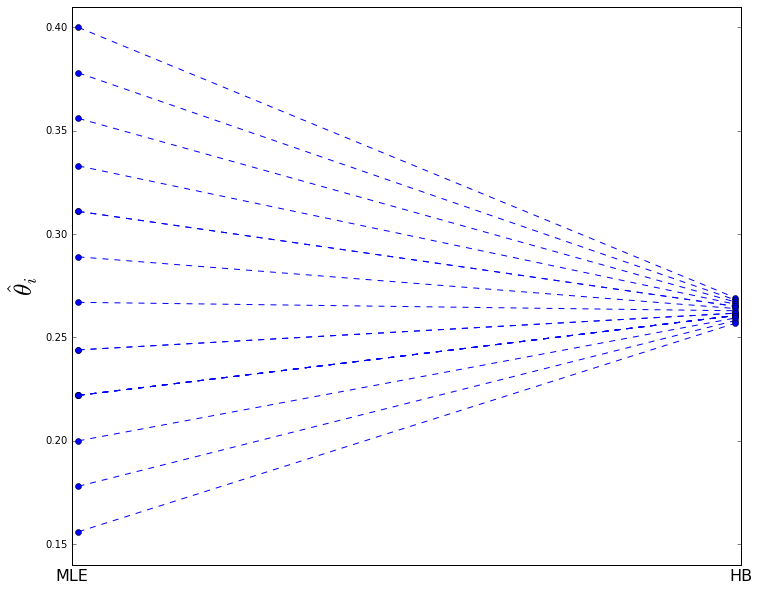

In [9]:
fig = plt.figure(figsize = (12,10))
ax = fig.add_subplot(111)
x_plt = np.array([0.01,0.99])
for i in range(N):
    y_plt = np.array([theta_MLE[i], theta_hat[i]])
    ax.plot(x_plt,y_plt, 'b--o')
ax.set_ylabel(r'$\hat{\theta}_i$', size = 25)
ax.set_ylim([0.14, 0.41])
ax.set_xticks(np.arange(0,1.01,1))
fig.canvas.draw()
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'MLE'
labels[1] = 'HB'
ax.set_xticklabels(labels)
ax.tick_params(axis = 'x', labelsize = 16)

They all seem to be very closer to each other than initially thought! Let's see if we actually made better predictions: we take the batting averages over the complete season as the "true" value (ie, we are actually doing MLE now on the bigger dataset, which is ok because given enough data the likelihood overwhelms the prior). We now plot the two estimators (simple MLE vs HB) against the full season.

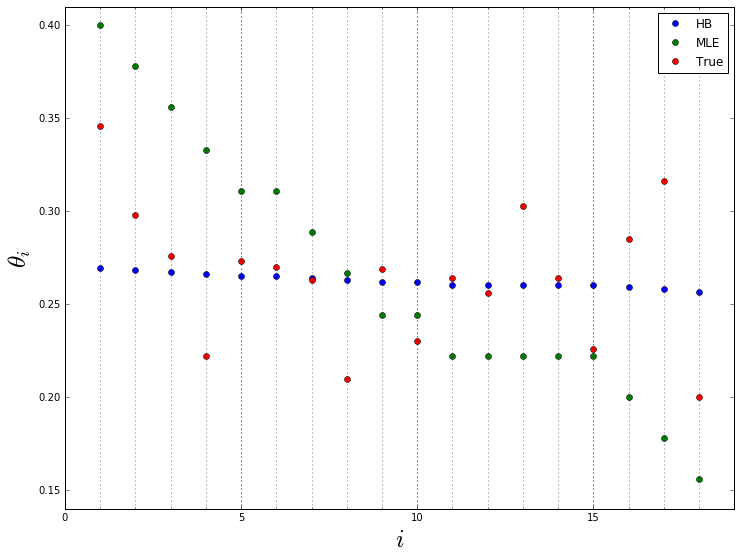

In [10]:
x_n = np.arange(N)
fig = plt.figure(figsize = (12,9))
ax = fig.add_subplot(111)
ax.plot(x_n+1, theta_hat, 'bo', label = 'HB')
ax.plot(x_n+1, theta_MLE, 'go', label = 'MLE')
ax.plot(x_n+1, theta_true, 'ro', label = 'True')
leg = ax.legend(numpoints = 1)
ax.set_xlim([0., 19])
ax.set_ylim([0.14, 0.41])
ax.set_xlabel(r'$i$', size = 25)
ax.set_ylabel(r'$\theta_i$', size = 25)
ax.set_xticks(np.arange(1, N+1, 1), minor = True)
ax.xaxis.grid(True, which = 'both')
plt.show()

Looks much better! On average the hierarchical Bayes seems like a better guess than the MLE estimation. Let's calculate the actual error rates:

In [12]:
err_mle = np.sum(np.abs(theta_MLE-theta_true))/N
err_hb = np.sum(np.abs(theta_hat-theta_true))/N
print('Average error MLE: %.3f' % err_mle)
print('Average error HB: %.3f' % err_hb)
print('Ratio: %.2f' % (err_mle / err_hb))

Average error MLE: 0.055
Average error HB: 0.027
Ratio: 2.02


Half the error rate, not bad!